In [21]:
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
from iit_tpm import make_tpm, tpm_series
from grn_tpm import iit_tpm_cal

def decimal_to_binary(decimal, min_length=1):
    if min_length == 0:
        return ''
    if decimal == 0:
        return "0" if min_length == 1 else "0".zfill(min_length)
    binary = ""
    while decimal > 0:
        binary = str(decimal % 2) + binary
        decimal = decimal // 2
    # 使用 zfill 确保二进制字符串至少有 min_length 长度
    return binary.zfill(min_length)

# 不同环境状态下系统演化序列比较

In [22]:
# w1 = {
#     'w1': 0.9,
#     'w2': 0.9,
#     'w3': 0.9,
#     'w4': 0.8,
#     'w5': -0.01,
#     'w6': -0.01
# }

# w2 = {
#     'w1': 0.05,
#     'w2': 0.05,
#     'w3': 0.05,
#     'w4': 0,
#     'w5': -0.9,
#     'w6': -0.9
# }

w1 = {
    'w1': 0.9,
    'w2': 0.9,
    'w3': 0.9,
    'w4': 0.8,
    'w5': 0.3,
    'w6': 0.1
}

w2 = {
    'w1': 0.1,
    'w2': 0.1,
    'w3': 0.1,
    'w4': 0.1,
    'w5': -0.9,
    'w6': -0.9
}

bnet = {
    ('A', 'B'): 'w1',
    ('B', 'A'): 'w1',
    ('A', 'C'): 'w2',
    ('C', 'A'): 'w2',
    ('B', 'C'): 'w3',
    ('C', 'B'): 'w3',
    ('A', 'A'): 'w4',
    ('B', 'B'): 'w4',
    ('C', 'C'): 'w4',
    ('E1', 'A'): 'w5',
    ('E1', 'B'): 'w5',
    ('E1', 'C'): 'w5',
    ('E2', 'A'): 'w6',
    ('E2', 'B'): 'w6',
    ('E2', 'C'): 'w6',
}

In [23]:
tpm, tpm_v = make_tpm(bnet, w1, k=1)
un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2)

un:  0.25388133759156206
un_en:  0.12445311929938921
syn:  0.06578876958434327


In [ ]:
#### import matplotlib.pyplot as plt
import numpy as np

tpm, tpm_v = make_tpm(bnet, w1, k=10)
un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2)

colors = ["#BB4F4F", '#2A69B3', '#74B38F', '#FFA500']

steps = 30
# init_state = '010'
strs = [decimal_to_binary(i, min_length=3) for i in range(8)]
for init_state in strs:
    fig, ax = plt.subplots(figsize=(12,4),dpi=150)
    for indx,en in enumerate(["00", "01", "10", "11"]):
        en_state = en
        for seed in range(3):
            serie, serie_str = tpm_series(tpm_dic[en_state], init_state, steps, seed)

            # 由于二进制字符串不能直接作为y轴的值，我们可以使用它们的索引作为y轴的值
            ax.scatter(range(steps+1), serie, label='en_state:'+en_state, color=colors[indx])

    # 设置轴标签
    ax.set_xlabel('Time')
    ax.set_ylabel('System state')

    # 设置y轴的标签
    ax.set_yticks(range(8))
    ax.set_yticklabels(strs)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc=[1.01, 0])
    plt.title('w1_init='+init_state+'_syn='+str(syn))
    # 显示图形
    plt.show()

un:  0.49992315617323346
un_en:  0.18877877349036937
syn:  0.3112020855303125


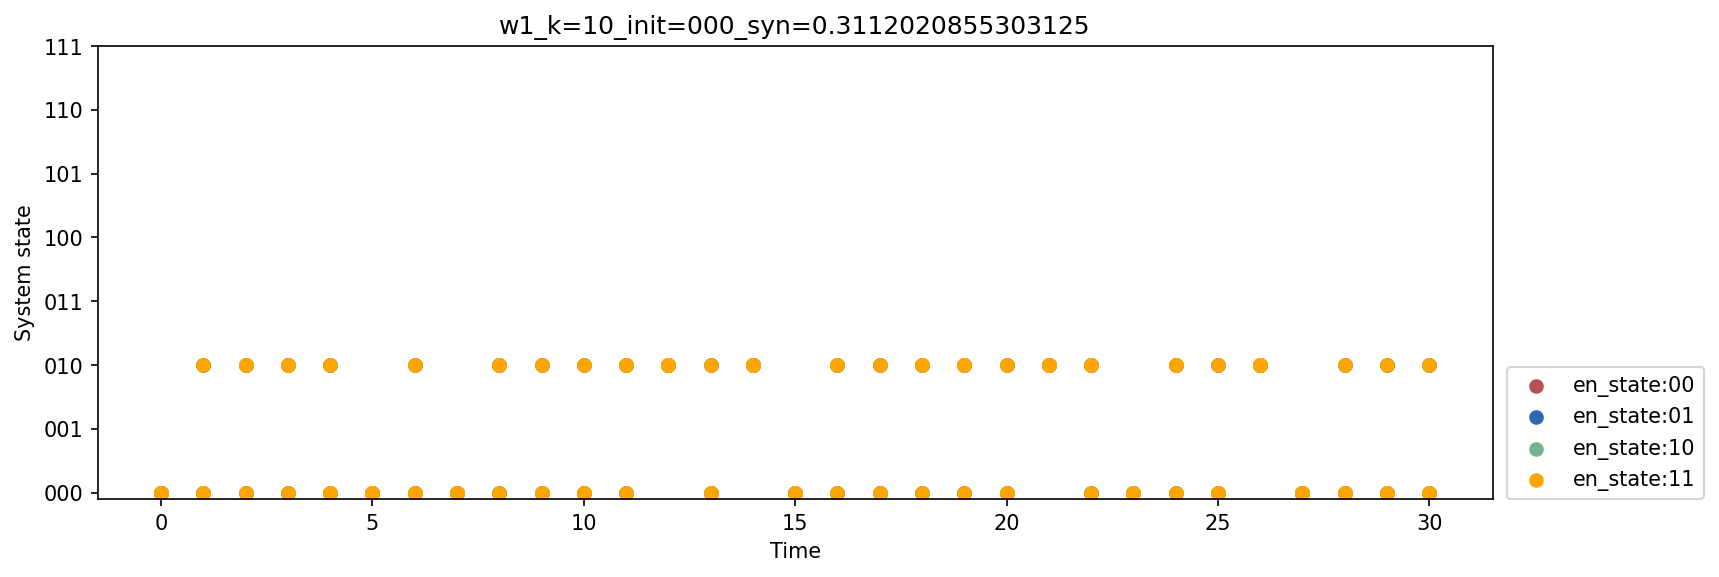

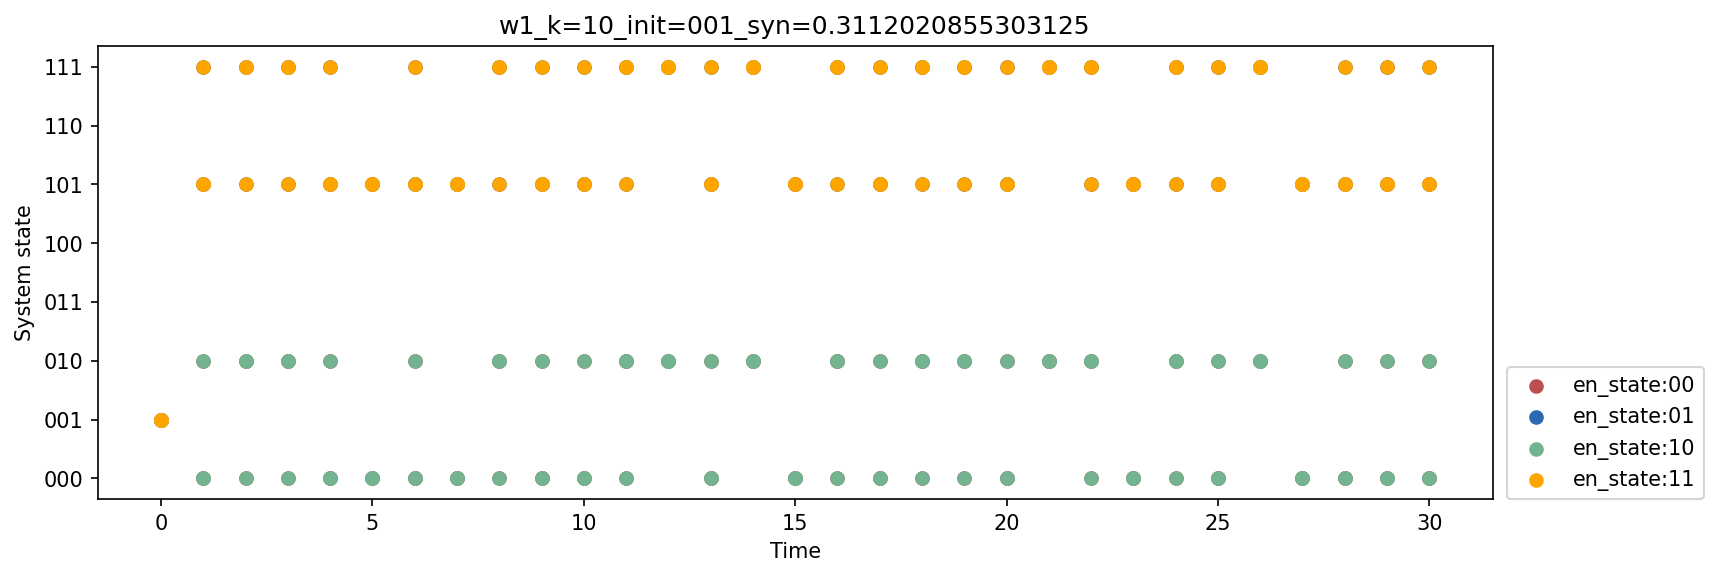

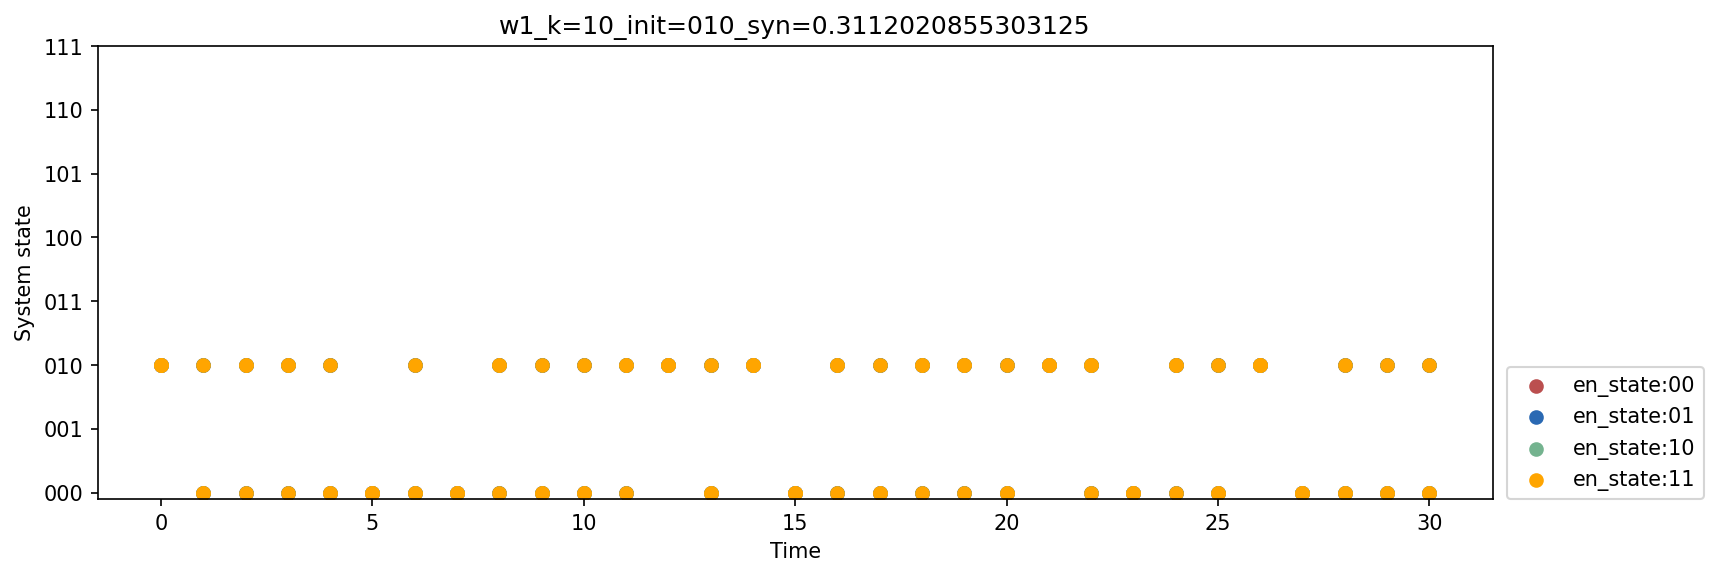

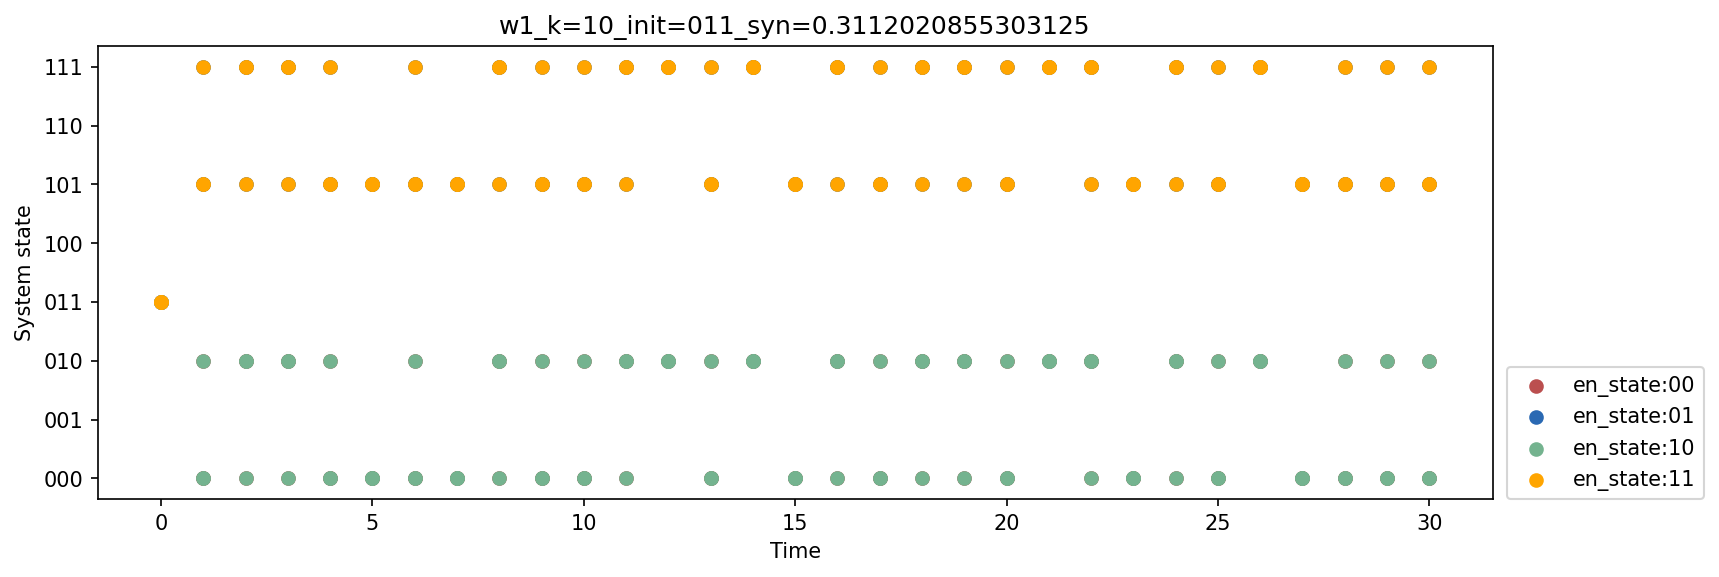

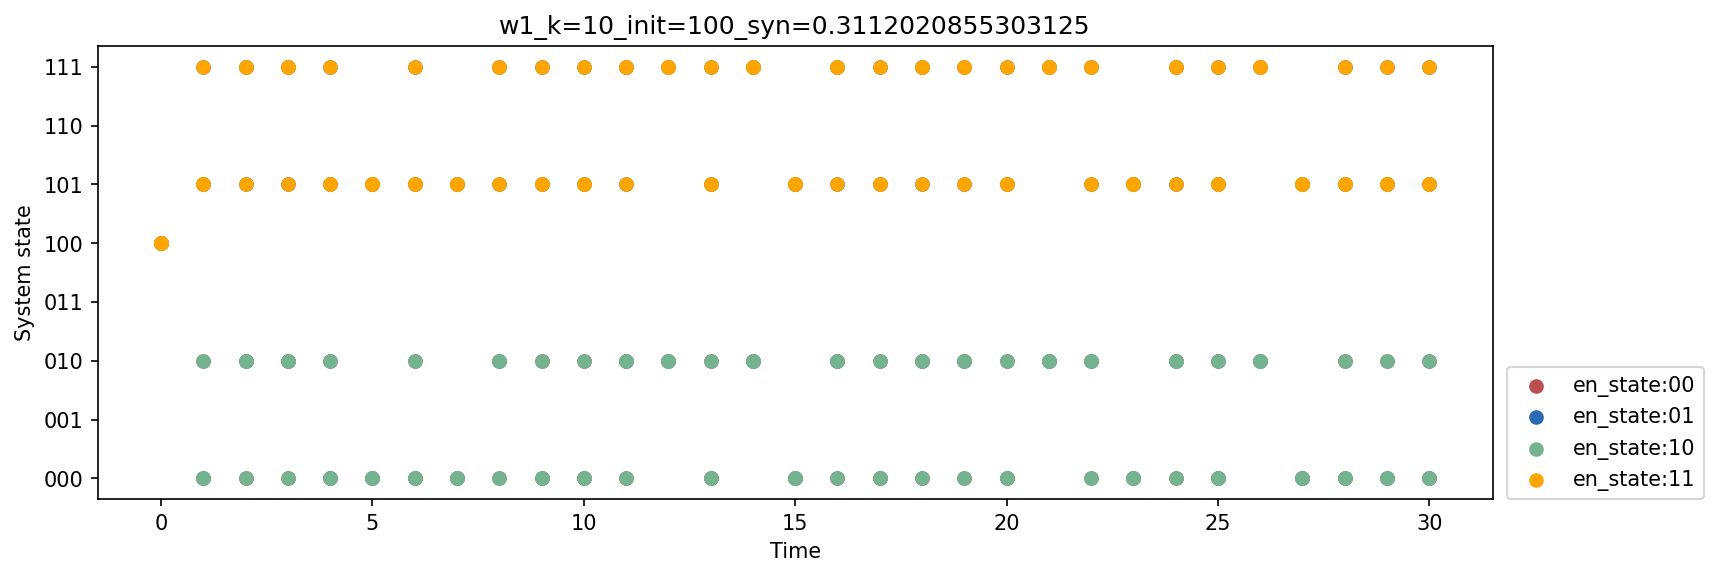

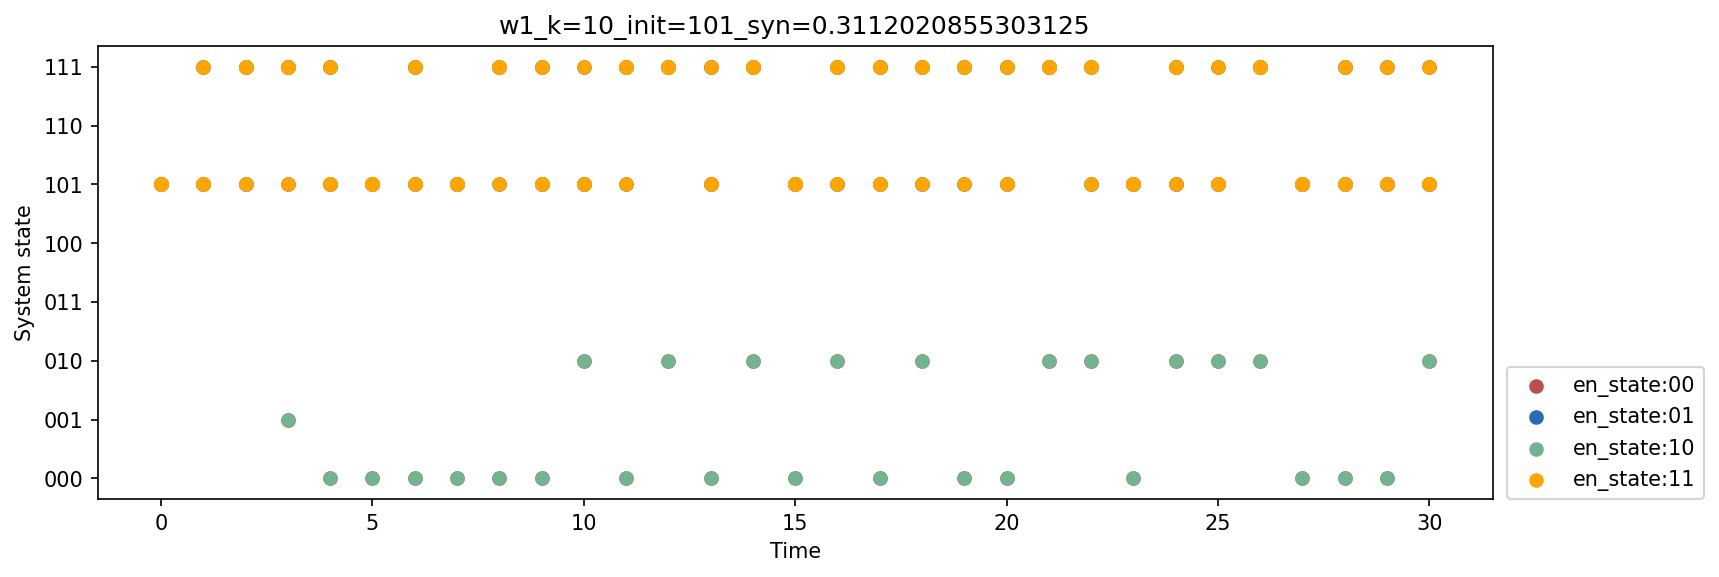

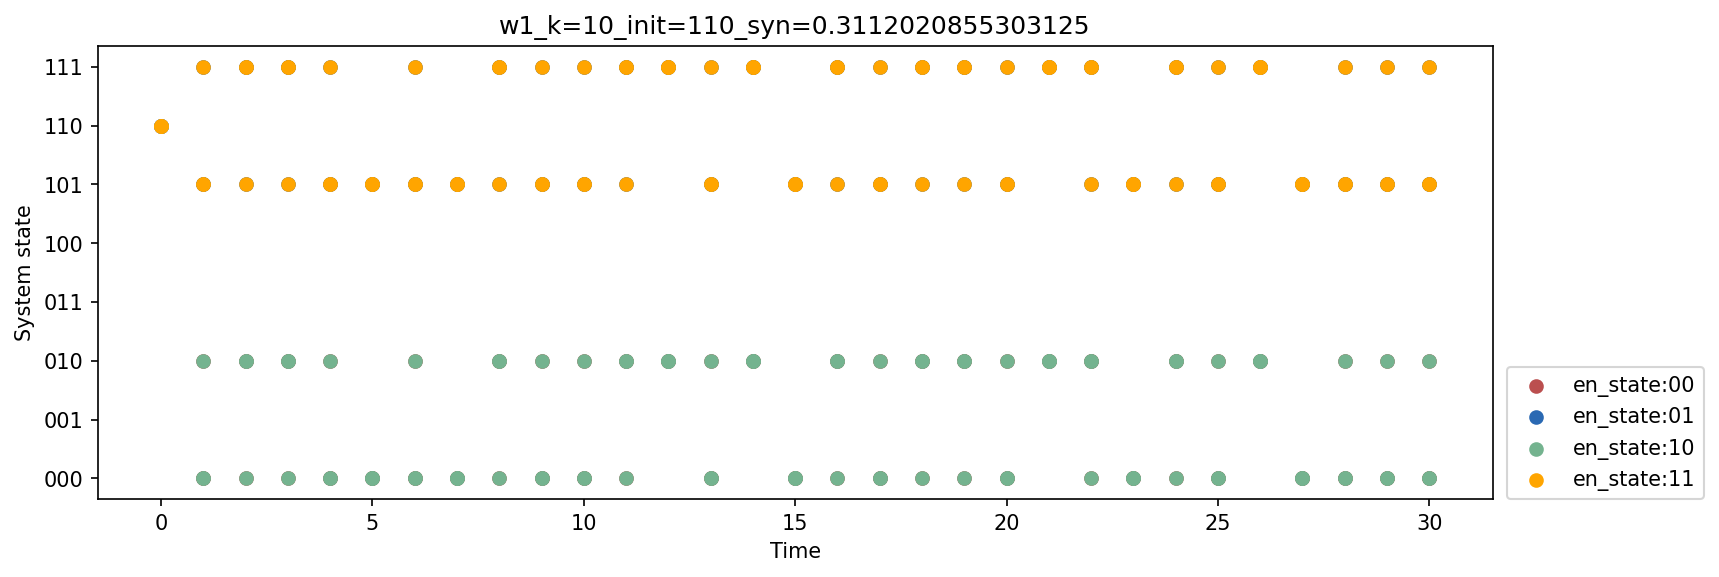

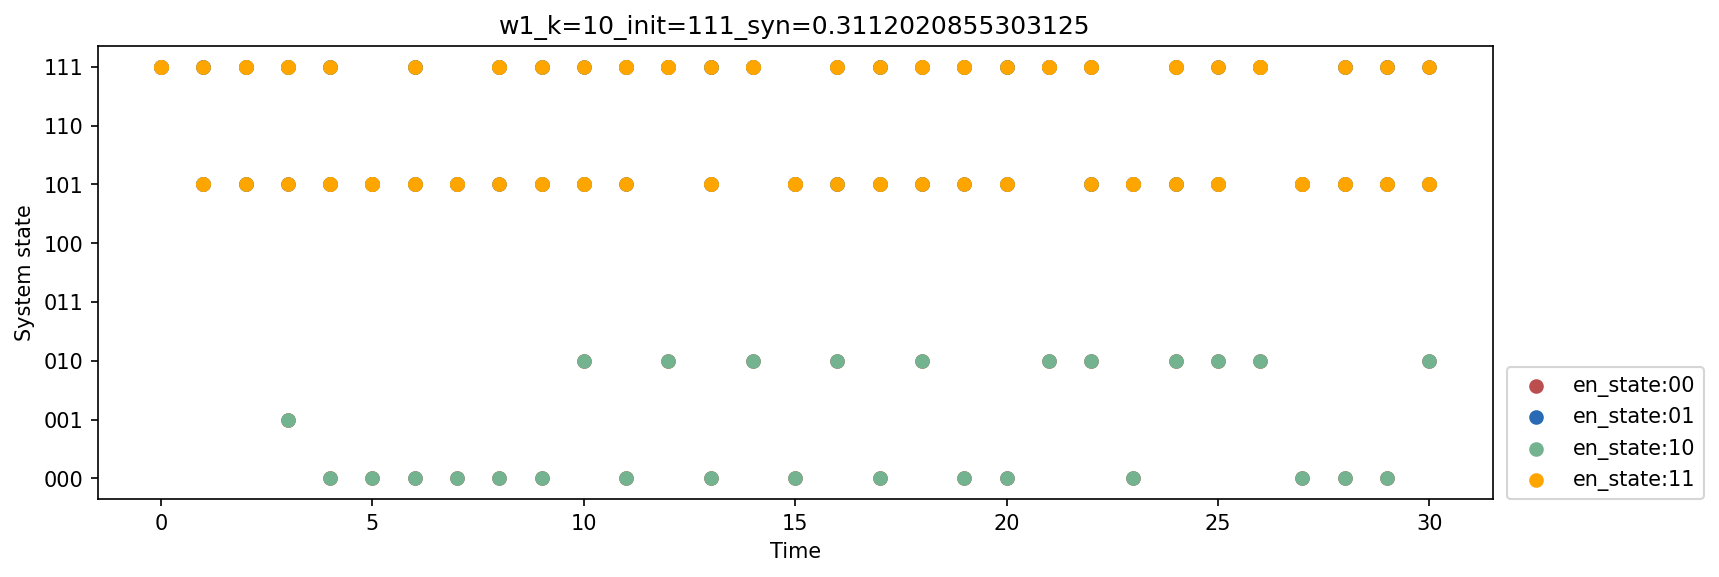

In [20]:
import matplotlib.pyplot as plt
import numpy as np
k = 10
tpm, tpm_v = make_tpm(bnet, w1, k=k)
un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2)

colors = ["#BB4F4F", '#2A69B3', '#74B38F', '#FFA500']

steps = 30
# init_state = '010'
strs = [decimal_to_binary(i, min_length=3) for i in range(8)]
for init_state in strs:
    fig, ax = plt.subplots(figsize=(12,4),dpi=150)
    for indx,en in enumerate(["00", "01", "10", "11"]):
        en_state = en
        for seed in range(3):
            serie, serie_str = tpm_series(tpm_dic[en_state], init_state, steps, seed)

            # 由于二进制字符串不能直接作为y轴的值，我们可以使用它们的索引作为y轴的值
            ax.scatter(range(steps+1), serie, label='en_state:'+en_state, color=colors[indx])

    # 设置轴标签
    ax.set_xlabel('Time')
    ax.set_ylabel('System state')

    # 设置y轴的标签
    ax.set_yticks(range(8))
    ax.set_yticklabels(strs)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc=[1.01, 0])
    plt.title('w1_k='+str(k)+'_init='+init_state+'_syn='+str(syn))
    # 显示图形
    plt.show()

# 最佳噪音实验复现

In [34]:
def serie_plot(bnet, w, k, steps, seeds=1):
    tpm, tpm_v = make_tpm(bnet, w, k=0.1)
    un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2)   
    colors = ["#BB4F4F", '#2A69B3', '#74B38F', '#FFA500']
    strs = [decimal_to_binary(i, min_length=3) for i in range(8)]
    for init_state in strs:
        fig, ax = plt.subplots(figsize=(10,4),dpi=150)
        for indx,en in enumerate(["00", "01", "10", "11"]):
            en_state = en
            for seed in range(seeds):
                serie, serie_str = tpm_series(tpm_dic[en_state], init_state, steps, seed)

                # 由于二进制字符串不能直接作为y轴的值，我们可以使用它们的索引作为y轴的值
                ax.scatter(range(steps+1), serie, label='en_state:'+en_state, color=colors[indx])

        # 设置轴标签
        ax.set_xlabel('Time')
        ax.set_ylabel('System state')

        # 设置y轴的标签
        ax.set_yticks(range(8))
        ax.set_yticklabels(strs)
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), loc=[1.01, 0])
        plt.title('w2_init='+init_state+'_syn='+str(syn))
        # 显示图形
        plt.show()
        
    return un_sys, un_en, syn

In [41]:
w2 = {
    'w1': 0.5,
    'w2': 0.5,
    'w3': 0.5,
    'w4': 0.5,
    'w11': 0.5,
    'w12': 0,
    'w13': 0,
    'w6': 0
}

bnet = {
    ('A', 'B'): 'w1',
    ('B', 'A'): 'w1',
    ('A', 'C'): 'w2',
    ('C', 'A'): 'w2',
    ('B', 'C'): 'w3',
    ('C', 'B'): 'w3',
    ('A', 'A'): 'w4',
    ('B', 'B'): 'w4',
    ('C', 'C'): 'w4',
    ('E1', 'A'): 'w11',
    ('E1', 'B'): 'w12',
    ('E1', 'C'): 'w13',
    ('E2', 'A'): 'w6',
    ('E2', 'B'): 'w6',
    ('E2', 'C'): 'w6',
}

un:  0.00224509401580595
un_en:  0.0008971987758207827
syn:  2.5186523354443074e-06
un:  0.7433927289593402
un_en:  0.19459778831396424
syn:  0.3832217427494585
un:  0.7433927290103627
un_en:  0.19459778831496408
syn:  0.38322174279981913
un:  0.7433927290103627
un_en:  0.19459778831496408
syn:  0.38322174279981913
un:  0.7433927290103627
un_en:  0.19459778831496408
syn:  0.38322174279981913
un:  0.7433927290103627
un_en:  0.19459778831496408
syn:  0.38322174279981913
un:  0.7433927290103627
un_en:  0.19459778831496408
syn:  0.38322174279981913
un:  0.7433927290103627
un_en:  0.19459778831496408
syn:  0.38322174279981913
un:  0.7433927290103627
un_en:  0.19459778831496408
syn:  0.38322174279981913


/home/yuanbing/data/test/ymz_nis/Local-EI-project/exp/bool_network/grn/iit_tpm.py:74: RuntimeWarning: overflow encountered in exp
  states_to_units_pos_tpm = 1. / (1. + np.exp(-k * s_values @ wm))


un:  0.7433927290103627
un_en:  0.19459778831496408
syn:  0.38322174279981913
un:  0.7433927290103627
un_en:  0.19459778831496408
syn:  0.38322174279981913
un:  0.7433927290103627
un_en:  0.19459778831496408
syn:  0.38322174279981913
un:  0.7433927290103627
un_en:  0.19459778831496408
syn:  0.38322174279981913
un:  0.7433927290103627
un_en:  0.19459778831496408
syn:  0.38322174279981913
un:  0.7433927290103627
un_en:  0.19459778831496408
syn:  0.38322174279981913
un:  0.7433927290103627
un_en:  0.19459778831496408
syn:  0.38322174279981913
un:  0.7433927290103627
un_en:  0.19459778831496408
syn:  0.38322174279981913
un:  0.7433927290103627
un_en:  0.19459778831496408
syn:  0.38322174279981913
un:  0.7433927290103627
un_en:  0.19459778831496408
syn:  0.38322174279981913
un:  0.7433927290103627
un_en:  0.19459778831496408
syn:  0.38322174279981913


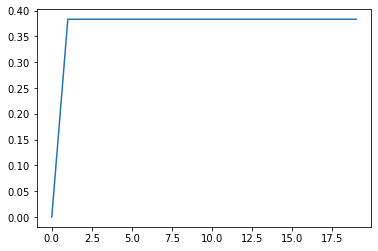

In [43]:
import matplotlib.pyplot as plt
import numpy as np

syn_list = []
for k in np.linspace(0.1, 1000, 20):
    tpm, tpm_v = make_tpm(bnet, w2, k=k)
    un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2) 
    syn_list.append(syn)
plt.plot(syn_list)

# 梯径分析序列

In [3]:
import string

# 获取所有小写字母
lowercase_letters = list(string.ascii_lowercase)

# 获取所有大写字母
uppercase_letters = list(string.ascii_uppercase)

# 合并两个列表
all_letters = lowercase_letters + uppercase_letters



In [7]:
lens = 2000
init_state = '00111'
tpm1, tpm_v1 = make_tpm(bnet, w1, k=1)
for seed in range(3):
    serie, _ = tpm_series(tpm_v1, init_state, lens, seed)
    letter_list = [all_letters[i] for i in serie]
    with open('w1_'+init_state+'_'+str(seed)+'.txt', 'w') as f:
            f.write(''.join(letter_list))


In [8]:

tpm2, tpm_v2 = make_tpm(bnet, w2, k=1)
for seed in range(3):
    serie, _ = tpm_series(tpm_v2, init_state, lens, seed)
    letter_list = [all_letters[i] for i in serie]
    with open('w2_'+init_state+'_'+str(seed)+'.txt', 'w') as f:
            f.write(''.join(letter_list))